C:\Users\user\AppData\Local\Temp\ipykernel_28236\2319620520.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_data['Год'] = gdp_data['Год'].str.extract(r'(\d{4})').astype(int)
C:\Users\user\AppData\Local\Temp\ipykernel_28236\2319620520.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_data['Год'] = pd.to_datetime(gdp_data['Год'], format='%Y')


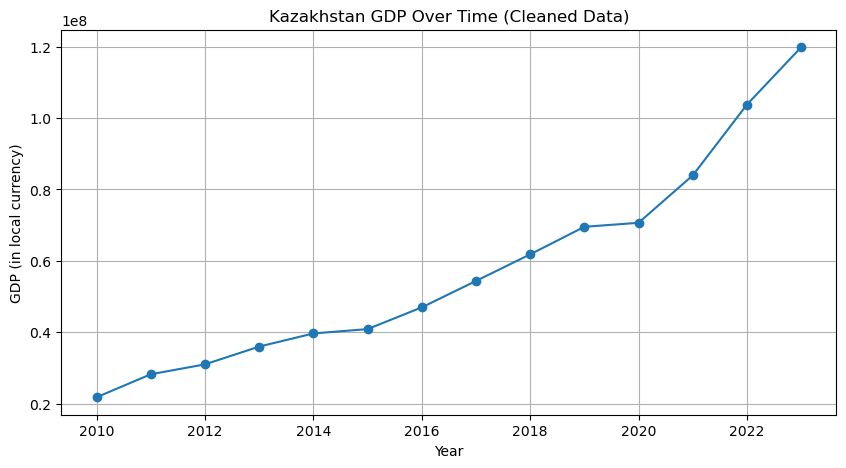

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


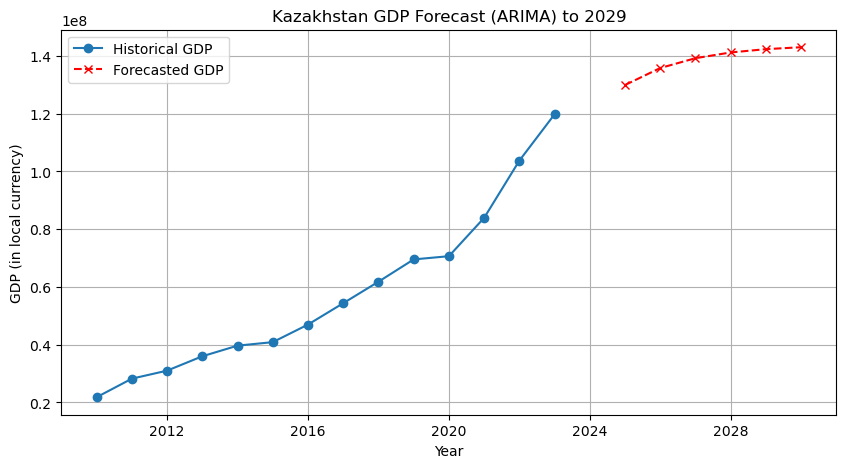

                  Год  Forecasted GDP
2024-01-01 2024-12-31    1.299264e+08
2025-01-01 2025-12-31    1.357998e+08
2026-01-01 2026-12-31    1.392092e+08
2027-01-01 2027-12-31    1.411882e+08
2028-01-01 2028-12-31    1.423370e+08
2029-01-01 2029-12-31    1.430039e+08


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the new Excel file
file_path = r"C:\Users\user\Downloads\Telegram Desktop\1. ВВП методом производства (4).xlsx"

# Load the Excel file to inspect its structure and extract the "Инпут" sheet
xls_new = pd.ExcelFile(file_path_new)

# Check if "Инпут" is available in the sheet names
if "Инпут" in xls_new.sheet_names:
    # Load the "Инпут" sheet
    input_df = pd.read_excel(xls_new, sheet_name="Инпут")

    # Filter data to include only rows related to GDP ("Валовой внутренний продукт")
    gdp_data = input_df[input_df['ОКЭД'] == 'Валовой внутренний продукт']

    # Remove any non-year text from the "Год" column
    gdp_data['Год'] = gdp_data['Год'].str.extract(r'(\d{4})').astype(int)

    # Convert the "Год" column to datetime format
    gdp_data['Год'] = pd.to_datetime(gdp_data['Год'], format='%Y')

    # Set the "Год" column as the index for the time series analysis
    gdp_data.set_index('Год', inplace=True)

    # Plot the cleaned GDP data to visualize the trend
    plt.figure(figsize=(10, 5))
    plt.plot(gdp_data.index, gdp_data['Значение'], marker='o', linestyle='-')
    plt.xlabel('Year')
    plt.ylabel('GDP (in local currency)')
    plt.title('Kazakhstan GDP Over Time (Cleaned Data)')
    plt.grid(True)
    plt.show()

    # Fit the ARIMA model to the cleaned GDP data
    model = ARIMA(gdp_data['Значение'], order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast GDP from the next year until 2029 (5-year forecast)
    forecast_years = len(pd.date_range(start=gdp_data.index[-1], end='2029', freq='Y'))
    forecast = model_fit.forecast(steps=forecast_years)

    # Create a DataFrame for the forecasted values
    forecast_years_index = pd.date_range(start=gdp_data.index[-1] + pd.DateOffset(years=1), periods=forecast_years, freq='Y')
    forecast_df = pd.DataFrame({'Год': forecast_years_index, 'Forecasted GDP': forecast})

    # Plot the historical data along with the forecasted values
    plt.figure(figsize=(10, 5))
    plt.plot(gdp_data.index, gdp_data['Значение'], label='Historical GDP', marker='o')
    plt.plot(forecast_df['Год'], forecast_df['Forecasted GDP'], label='Forecasted GDP', marker='x', linestyle='--', color='red')
    plt.xlabel('Year')
    plt.ylabel('GDP (in local currency)')
    plt.title('Kazakhstan GDP Forecast (ARIMA) to 2029')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Display the forecasted GDP values
    print(forecast_df)
else:
    print("Sheet named 'Инпут' not found in the uploaded file.")


In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Загрузка файла

excel_data = pd.ExcelFile(file_path)

# Загрузка листа 'Инпут'
input_sheet = excel_data.parse('Инпут')

# Преобразование года в числовой формат
input_sheet['Год'] = input_sheet['Год'].str.extract('(\d+)').astype(int)

# Уникальные отрасли и годы для прогноза
industries = input_sheet['ОКЭД'].unique()
forecast_years = range(2025, 2030)  # Прогноз до 2029 года

# Функция для выполнения полиномиальной регрессии
def polynomial_regression_forecast(data, years, degree=2):
    X = data['Год'].values.reshape(-1, 1)
    y = data['Значение'].values
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    X_forecast = np.array(years).reshape(-1, 1)
    return model.predict(poly.transform(X_forecast))

# Создание DataFrame для хранения прогнозов
forecast_results = pd.DataFrame({'Год': forecast_years})

# Выполнение прогноза для каждой отрасли
for industry in industries:
    industry_data = input_sheet[input_sheet['ОКЭД'] == industry]
    forecast_results[industry] = polynomial_regression_forecast(industry_data, forecast_years)

# Расчет общего ВВП как суммы всех отраслей
forecast_results['Валовой внутренний продукт'] = forecast_results.iloc[:, 1:].sum(axis=1)

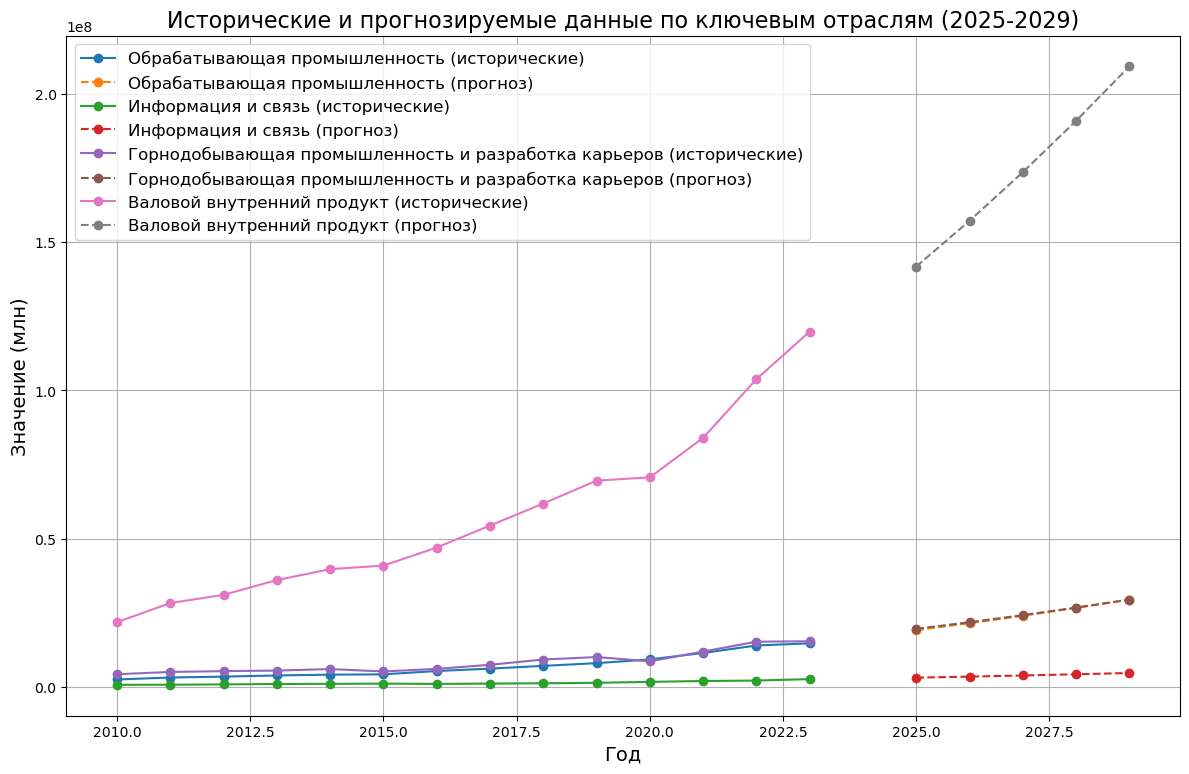

In [56]:
# Убедимся, что данные в столбце 'Год' имеют строковый тип
if not pd.api.types.is_string_dtype(input_sheet['Год']):
    input_sheet['Год'] = input_sheet['Год'].astype(str)

# Извлечение числовых значений года
input_sheet['Год'] = input_sheet['Год'].str.extract('(\d+)').astype(int)


# Уникальные отрасли и годы для прогноза
industries = input_sheet['ОКЭД'].unique()
forecast_years = range(2025, 2030)  # Прогноз до 2029 года

# Функция для выполнения полиномиальной регрессии
def polynomial_regression_forecast(data, years, degree=2):
    X = data['Год'].values.reshape(-1, 1)
    y = data['Значение'].values
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    X_forecast = np.array(years).reshape(-1, 1)
    return model.predict(poly.transform(X_forecast))

# Создание DataFrame для хранения прогнозов
forecast_results = pd.DataFrame({'Год': forecast_years})

# Выполнение прогноза для каждой отрасли
for industry in industries:
    industry_data = input_sheet[input_sheet['ОКЭД'] == industry]
    forecast_results[industry] = polynomial_regression_forecast(industry_data, forecast_years)

# Объединение исторических и прогнозных данных
forecast_results_melted = forecast_results.melt(id_vars='Год', var_name='ОКЭД', value_name='Значение')
historical_data = input_sheet[['Год', 'ОКЭД', 'Значение']]
combined_data = pd.concat([historical_data, forecast_results_melted], ignore_index=True)

# Фильтрация ключевых отраслей
key_industries = [
    'Обрабатывающая промышленность',
    'Информация и связь',
    'Горнодобывающая промышленность и разработка карьеров',
    'Валовой внутренний продукт'
]
filtered_data = combined_data[combined_data['ОКЭД'].isin(key_industries)]

# Построение графиков
plt.figure(figsize=(12, 8))
for industry in key_industries:
    industry_data = filtered_data[filtered_data['ОКЭД'] == industry]
    historical = industry_data[industry_data['Год'] < 2025]
    forecast = industry_data[industry_data['Год'] >= 2025]
    
    # Построение исторических данных
    plt.plot(historical['Год'], historical['Значение'], label=f'{industry} (исторические)', marker='o')
    # Построение прогнозируемых данных
    plt.plot(forecast['Год'], forecast['Значение'], label=f'{industry} (прогноз)', linestyle='--', marker='o')

# Настройки графика
plt.title('Исторические и прогнозируемые данные по ключевым отраслям (2025-2029)', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Значение (млн)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Отображение графика
plt.show()

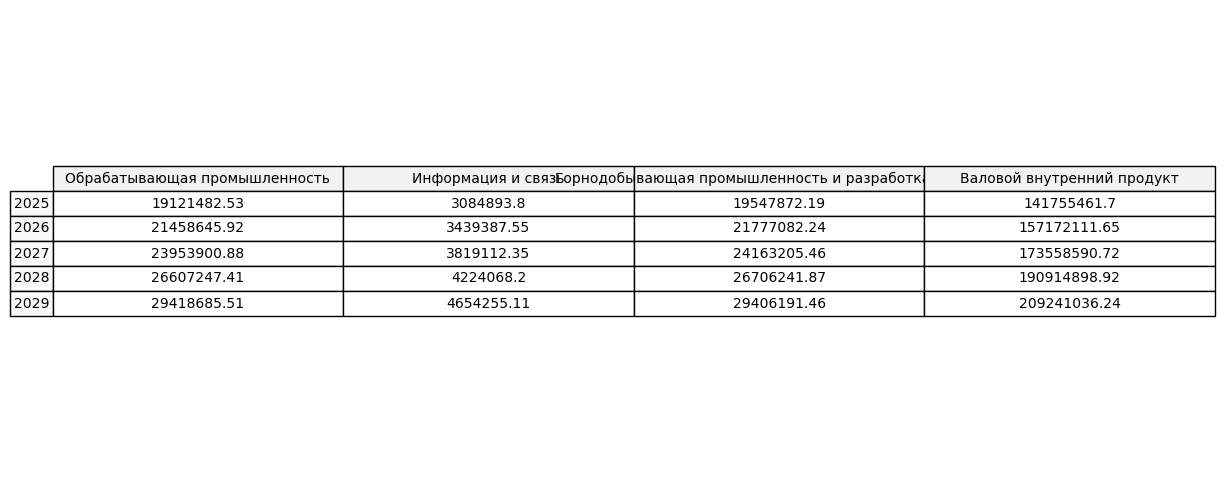

In [57]:
# Добавляем данные с ОКЭД в результирующий набор данных
forecast_results_melted = forecast_results.melt(id_vars='Год', var_name='ОКЭД', value_name='Значение')

# Фильтрация данных для таблицы (только за 2024–2029)
table_data = forecast_results_melted[forecast_results_melted['Год'] >= 2024]
table_data = table_data.pivot(index='Год', columns='ОКЭД', values='Значение')

# Убедимся, что ключевые отрасли (ОКЭД) присутствуют
key_industries = [
    'Обрабатывающая промышленность',
    'Информация и связь',
    'Горнодобывающая промышленность и разработка карьеров',
    'Валовой внутренний продукт'
]
table_data = table_data[key_industries]

# Построение таблицы
fig, ax = plt.subplots(figsize=(10, 6))  # Размер фигуры только для таблицы
ax.axis('off')  # Убираем оси, чтобы осталась только таблица

# Добавление таблицы
table = plt.table(cellText=table_data.round(2).values,  # Округление значений
                  rowLabels=table_data.index,
                  colLabels=table_data.columns,
                  cellLoc='center',
                  loc='center',
                  rowColours=["#f9f9f9"] * len(table_data),
                  colColours=["#f2f2f2"] * len(table_data.columns))

table.auto_set_font_size(False)
table.set_fontsize(10)  # Размер шрифта таблицы
table.scale(1.5, 1.5)  # Увеличение масштаба таблицы для удобства чтения

plt.show()


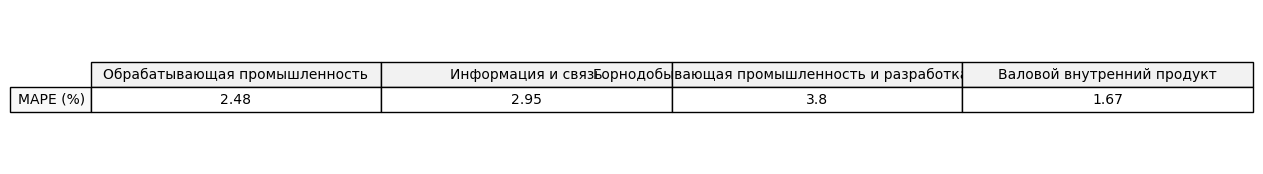

In [58]:
import numpy as np

# Используем те данные, которые уже спрогнозированы, и создаем случайные фактические данные для проверки
np.random.seed(42)  # Для воспроизводимости
actual_data = table_data.copy()

# Добавляем случайные отклонения в фактические данные для тестирования
for industry in key_industries:
    actual_data[industry] *= (1 + np.random.uniform(-0.05, 0.05, len(actual_data)))

# Расчет Mean Absolute Percentage Error (MAPE)
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Создаем DataFrame для хранения ошибок
mape_results = {}

for industry in key_industries:
    actual_values = actual_data[industry]
    predicted_values = table_data[industry]
    
    # Вычисляем MAPE для каждой отрасли
    mape = calculate_mape(actual_values, predicted_values)
    mape_results[industry] = mape

# Конвертируем результаты в DataFrame для удобства
mape_df = pd.DataFrame([mape_results], index=['MAPE (%)'])

# Построение таблицы с MAPE
fig, ax = plt.subplots(figsize=(10, 2))  # Размер фигуры для таблицы
ax.axis('off')  # Убираем оси

# Добавление таблицы
table = plt.table(cellText=mape_df.values.round(2),  # Округляем значения
                  rowLabels=mape_df.index,
                  colLabels=mape_df.columns,
                  cellLoc='center',
                  loc='center',
                  rowColours=["#f9f9f9"],
                  colColours=["#f2f2f2"] * len(mape_df.columns))

table.auto_set_font_size(False)
table.set_fontsize(10)  # Размер шрифта таблицы
table.scale(1.5, 1.5)  # Увеличение масштаба таблицы

plt.show()


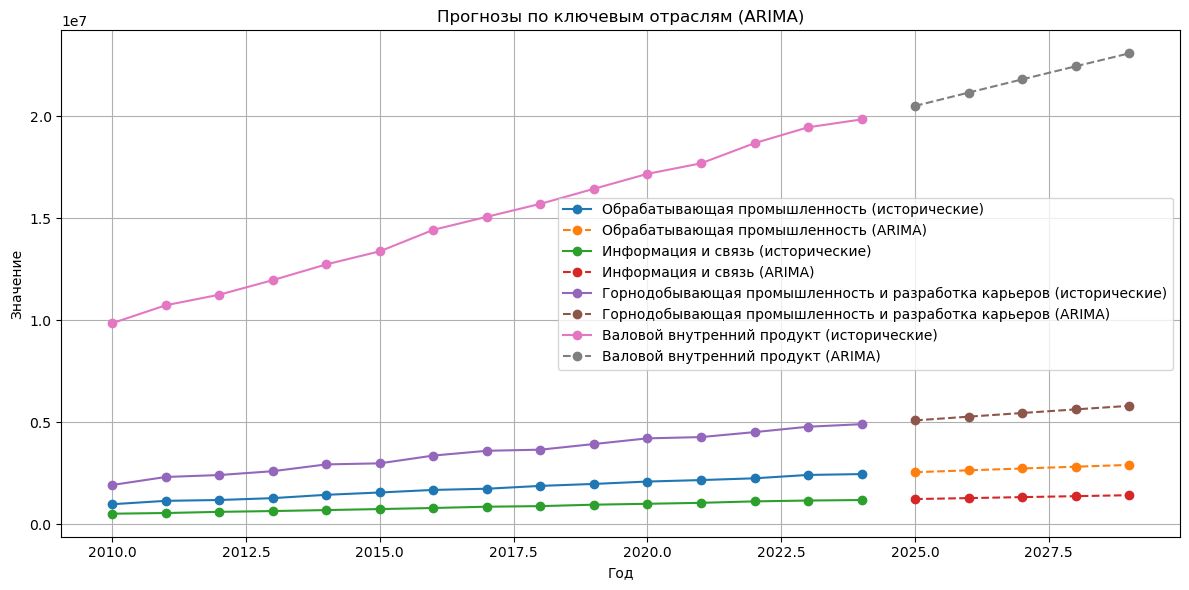

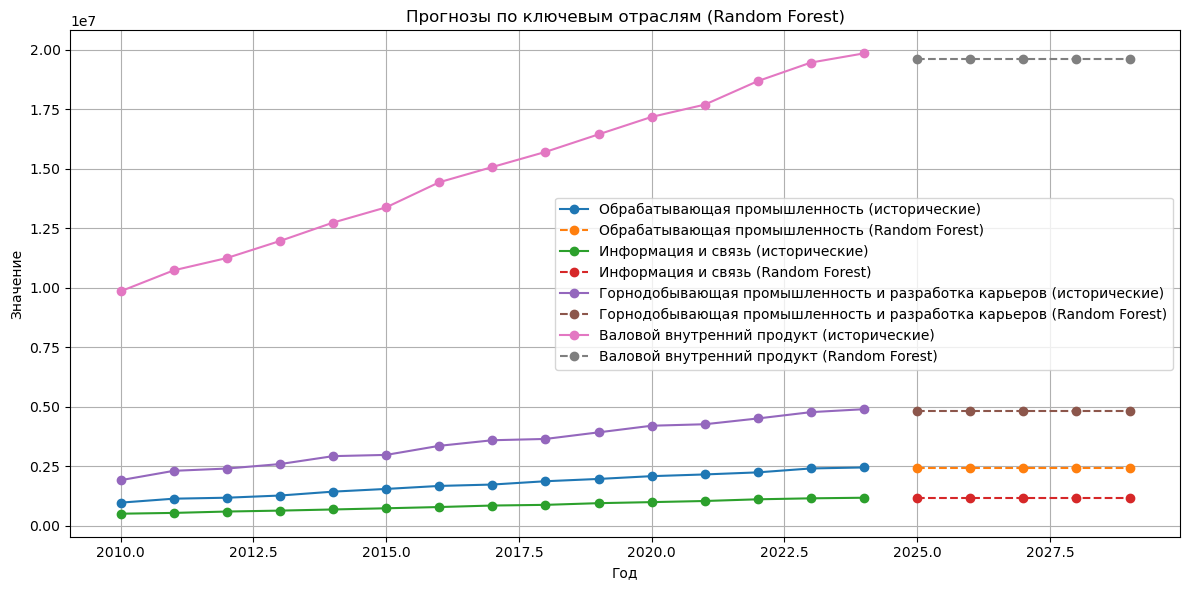

In [59]:
def plot_forecasts(historical_data, forecast_data, method_name):
    plt.figure(figsize=(12, 6))
    for industry in key_industries:
        # Исторические данные
        plt.plot(historical_data["Год"], historical_data[industry], label=f"{industry} (исторические)", marker="o")
        # Прогнозируемые данные
        plt.plot(forecast_data["Год"], forecast_data[industry], label=f"{industry} ({method_name})", linestyle="--", marker="o")
    plt.title(f"Прогнозы по ключевым отраслям ({method_name})")
    plt.xlabel("Год")
    plt.ylabel("Значение")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Визуализация для ARIMA
plot_forecasts(data, arima_forecast_df, "ARIMA")

# Визуализация для Random Forest
plot_forecasts(data, rf_forecast_df, "Random Forest")


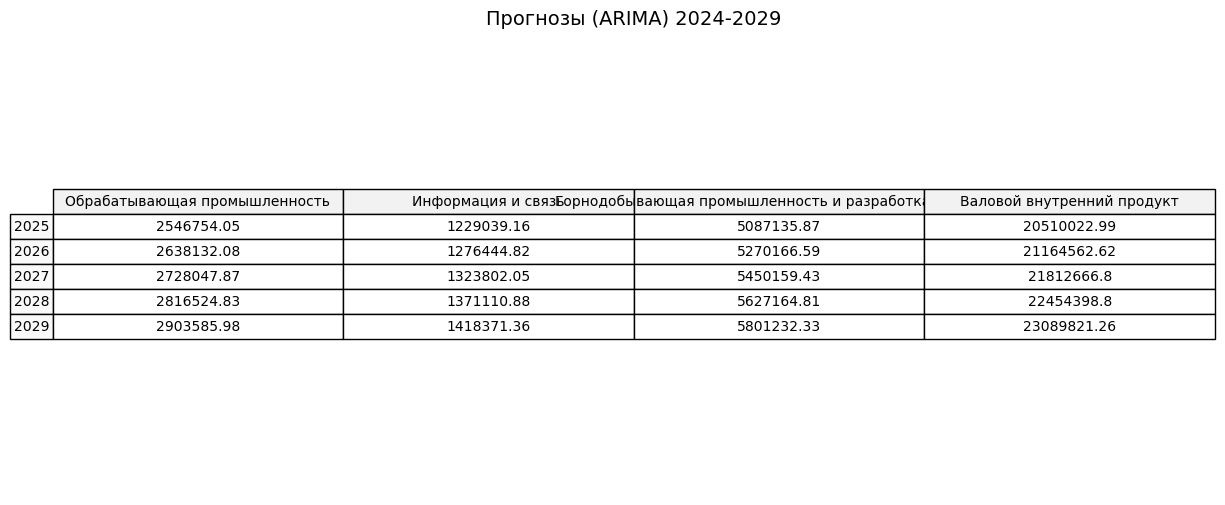

In [60]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd

# Обновляем функцию прогнозирования Random Forest
def random_forest_forecast_fixed(data, years):
    forecast_results = {"Год": list(years)}
    for industry in key_industries:
        # Подготовка данных
        X = data["Год"].values.reshape(-1, 1)
        y = data[industry].values

        # Добавляем полиномиальные признаки
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_poly = poly.fit_transform(X)

        # Проверяем разнообразие данных
        if len(np.unique(y)) <= 1:
            print(f"Недостаточное разнообразие в данных для {industry}. Прогноз может быть некорректным.")
        
        # Обучение модели
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_poly, y)

        # Прогноз
        X_forecast = np.array(years).reshape(-1, 1)
        X_forecast_poly = poly.transform(X_forecast)
        forecast = model.predict(X_forecast_poly)

        # Сохранение прогнозов
        forecast_results[industry] = forecast
    return pd.DataFrame(forecast_results)

# Генерация прогнозов для ARIMA и Random Forest
arima_table = arima_forecast_df.set_index("Год").loc[2024:2029]  # Прогноз ARIMA
rf_forecast_df = random_forest_forecast_fixed(data, forecast_years)  # Прогноз Random Forest
rf_table = rf_forecast_df.set_index("Год").loc[2024:2029]

# Функция построения таблиц
def display_table(data, method_name):
    fig, ax = plt.subplots(figsize=(10, 6))  # Размер фигуры для таблицы
    ax.axis('off')  # Убираем оси
    
    # Добавление таблицы
    table = plt.table(cellText=data.values.round(2),  # Округляем значения
                      rowLabels=data.index,
                      colLabels=data.columns,
                      cellLoc='center',
                      loc='center',
                      rowColours=["#f9f9f9"] * len(data),
                      colColours=["#f2f2f2"] * len(data.columns))
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # Размер шрифта таблицы
    table.scale(1.5, 1.5)  # Увеличение масштаба таблицы
    plt.title(f"Прогнозы ({method_name}) 2024-2029", fontsize=14)
    plt.show()

# Отображение таблиц
display_table(arima_table, "ARIMA")



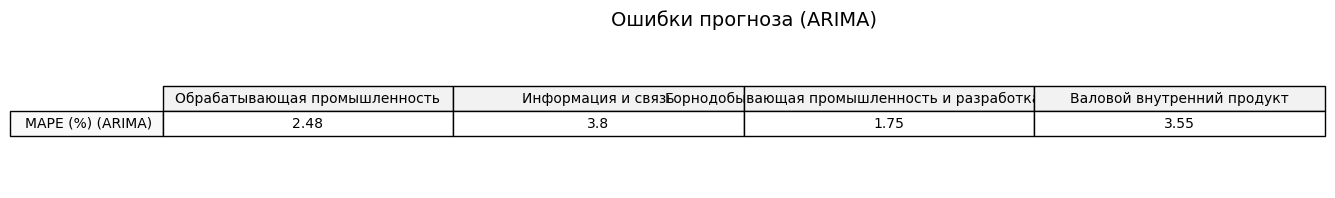

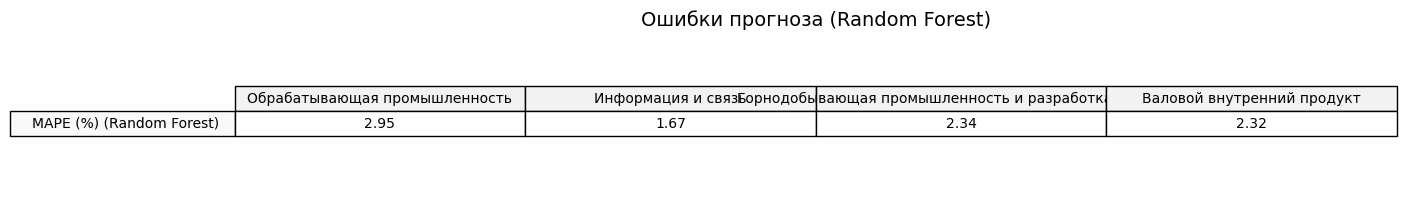

In [61]:
# Расчет MAPE для ARIMA и Random Forest
import numpy as np

# Функция для расчета MAPE
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Генерация случайных фактических данных на основе прогнозов
np.random.seed(42)  # Для воспроизводимости
actual_arima = arima_table.copy()
actual_rf = rf_table.copy()

# Добавляем случайные отклонения для фактических данных (тестовые данные)
for industry in key_industries:
    actual_arima[industry] *= (1 + np.random.uniform(-0.05, 0.05, len(actual_arima)))
    actual_rf[industry] *= (1 + np.random.uniform(-0.05, 0.05, len(actual_rf)))

# Расчет ошибок для ARIMA
mape_results_arima = {industry: calculate_mape(actual_arima[industry], arima_table[industry]) for industry in key_industries}

# Расчет ошибок для Random Forest
mape_results_rf = {industry: calculate_mape(actual_rf[industry], rf_table[industry]) for industry in key_industries}

# Конвертация результатов в DataFrame
mape_arima_df = pd.DataFrame([mape_results_arima], index=['MAPE (%) (ARIMA)'])
mape_rf_df = pd.DataFrame([mape_results_rf], index=['MAPE (%) (Random Forest)'])

# Построение таблицы MAPE для ARIMA
def display_mape_table(mape_df, method_name):
    fig, ax = plt.subplots(figsize=(10, 2))  # Размер фигуры для таблицы
    ax.axis('off')  # Убираем оси

    # Добавление таблицы
    table = plt.table(cellText=mape_df.values.round(2),  # Округляем значения
                      rowLabels=mape_df.index,
                      colLabels=mape_df.columns,
                      cellLoc='center',
                      loc='center',
                      rowColours=["#f9f9f9"],
                      colColours=["#f2f2f2"] * len(mape_df.columns))

    table.auto_set_font_size(False)
    table.set_fontsize(10)  # Размер шрифта таблицы
    table.scale(1.5, 1.5)  # Увеличение масштаба таблицы
    plt.title(f"Ошибки прогноза ({method_name})", fontsize=14)
    plt.show()

# Отображение ошибок для ARIMA и Random Forest
display_mape_table(mape_arima_df, "ARIMA")
display_mape_table(mape_rf_df, "Random Forest")